# Numerical differentiation of noisy data: Ground truth results

This notebook builds based on `1_basic_tutorial.ipynb` by calling optimization routines to find optimal parameters for each method.

### Notations:
  * dt: (float) step size (note: the symbol "dt" comes from differentiating timeseries data, however these functions work for a 1-dimensional spatial derivative as well)
  * x: (np.array with length N) the data you want to differentiate
  * x_hat: (np.array with length N) the smoothed estimate of x
  * x_truth: (np.array with length N) the true value of x (which is known when the data is simulated, and used for plotting purposes only)
  * dxdt_hat: (np.array with length N) the estimate of the derivative of x
  * dxdt_truth: (np.array with length N) the true value of dxdt (which is known when the data is simulated, and used for plotting purposes only)

In [1]:
import os, sys
# local import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pynumdiff.optimize import optimize
from pynumdiff.utils import evaluate
from pynumdiff.utils.simulate import sine, triangle, pop_dyn, linear_autonomous,\
	pi_control, lorenz_x
from pynumdiff.finite_difference import first_order, second_order
from pynumdiff.smooth_finite_difference import mediandiff, meandiff, gaussiandiff,\
    friedrichsdiff, butterdiff, splinediff
from pynumdiff.total_variation_regularization import velocity, acceleration,\
	jerk, iterative_velocity, smooth_acceleration
from pynumdiff.linear_model import spectraldiff, polydiff, savgoldiff, lineardiff
from pynumdiff.kalman_smooth import constant_velocity, constant_acceleration, constant_jerk

# 0. Simulate some data

pynumdiff comes with 6 different toy problems (choose the one that most resembles your data to see how the methods compare):
* lorenz_x: (nonlinear) x component of a lorenz attractor
* sine: (linear) sum of two sines
* pop_dyn: (nonlinear) bounded exponential growth
* triangle: (nonlinear) sharp-edged triangle wave with increasing frequency
* pi_control: (linear / nonlinear) linear proportional integral controller with nonlinear control inputs

In [2]:
# noise is generated using np.random, e.g. np.random.normal, np.random.uniform, np.random.poisson
# noise_type and noise_parameters should be compatible with np.random functions 
noise_type = 'normal'
noise_parameters = [0, 0.1]

# time step and time series length
dt = 0.01  # sampling time step
duration = 4 # sec
problem = pi_control # select one of the options imported from the simulate module

In [3]:
x, x_truth, dxdt_truth, extras = problem(duration, 
                                        noise_parameters=noise_parameters, 
                                        dt=dt)

For our toy problems we can optimize the parameters in one of two options:
1. Use the known dxdt to find the best parameters 
2. Actual dxdt is unknown

In the real world, option (1) is not possible, but this notebook focuses on this case. For the second case, see notebook 2b.

Use the following syntax, as detailed in the notebook:

```python
from pynumdiff.optimize import optimize
from pynumdiff.module import method

search_space = {'param1':[values], 'param2':[values], ...}

params, val = optimize(method, x, dt, search_space, 
                    tvgamma=tvgamma, # hyperparameter
                    dxdt_truth=dxdt_truth) # defaults to None if no ground truth data
   
x_hat, dxdt_hat = method(x, dt, **params)
```

where `param`s are keyword arguments that come from the method definition. If you don't know a search space, default search spaces are defined for all methods in `optimize.py`. Partial search spaces are accepted, simply `.update`d to the default search space. Reasonable upper and lower bounds are defined for numerical search space dimensions (type `int` or `float`). Data type `bool` can also be searched over, but searching over `str` parameters is currently not supported.

Since we are optimizing on the actual values, there is no need to regularize, so `optimize`'s `tvgamma` parameter is ignored during optimization.

## 1. Finite Difference

### 1.1 Finite Difference: Iterated First Order

(This is actually currently second order, per #104)

Optimal parameters:  {'num_iterations': 31}
RMS error in velocity:  0.9759210091448217


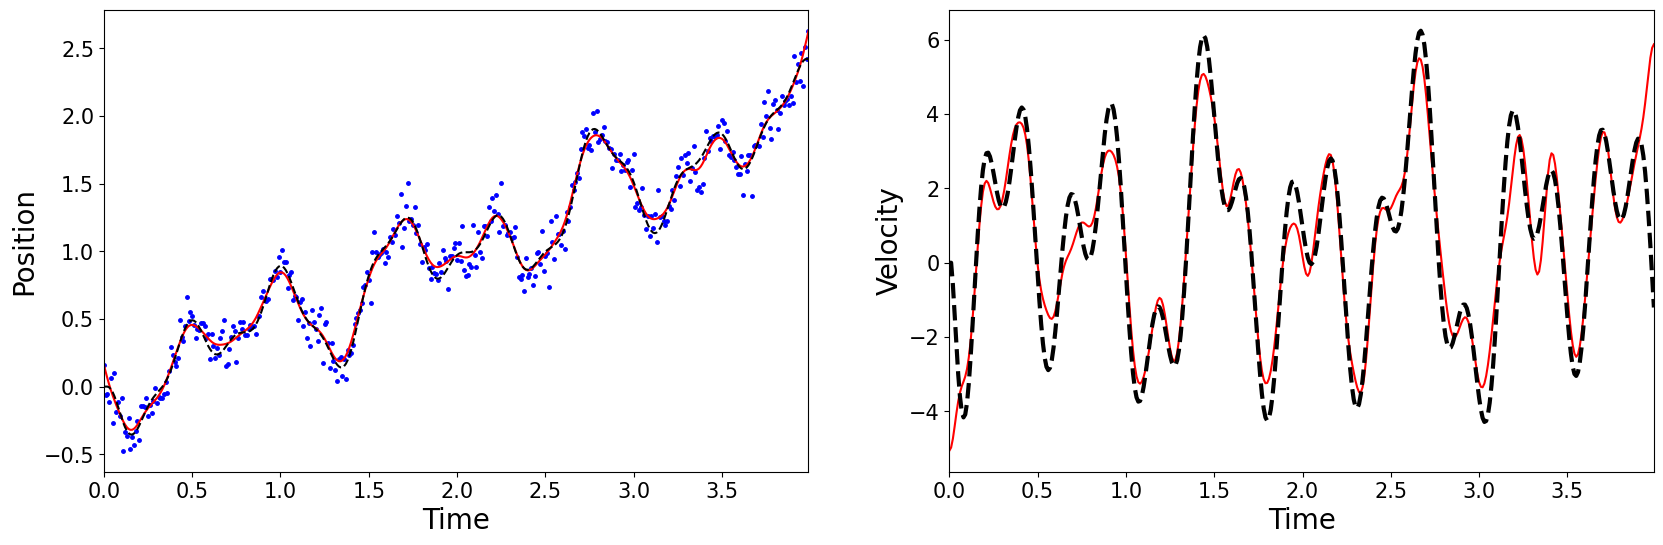

In [4]:
params, val = optimize(first_order, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = first_order(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 2. Smooth Finite Difference

### 2.1 Smooth Finite Difference: Median smoothing

Optimal parameters:  {'window_size': 15, 'num_iterations': 1}
RMS error in velocity:  1.6466883110997053


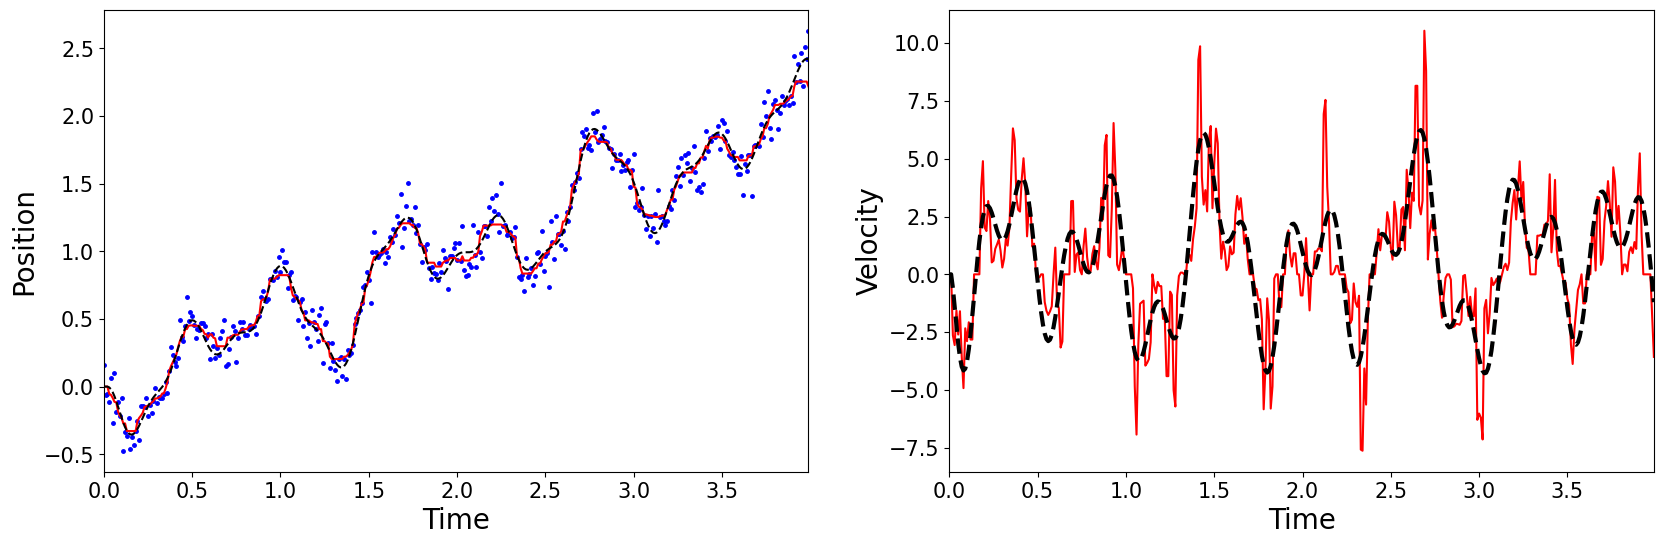

In [5]:
params, val = optimize(mediandiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = mediandiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.2 Smooth Finite Difference: Mean smoothing

Optimal parameters:  {'window_size': 5, 'num_iterations': 6}
RMS error in velocity:  0.6394938557605387


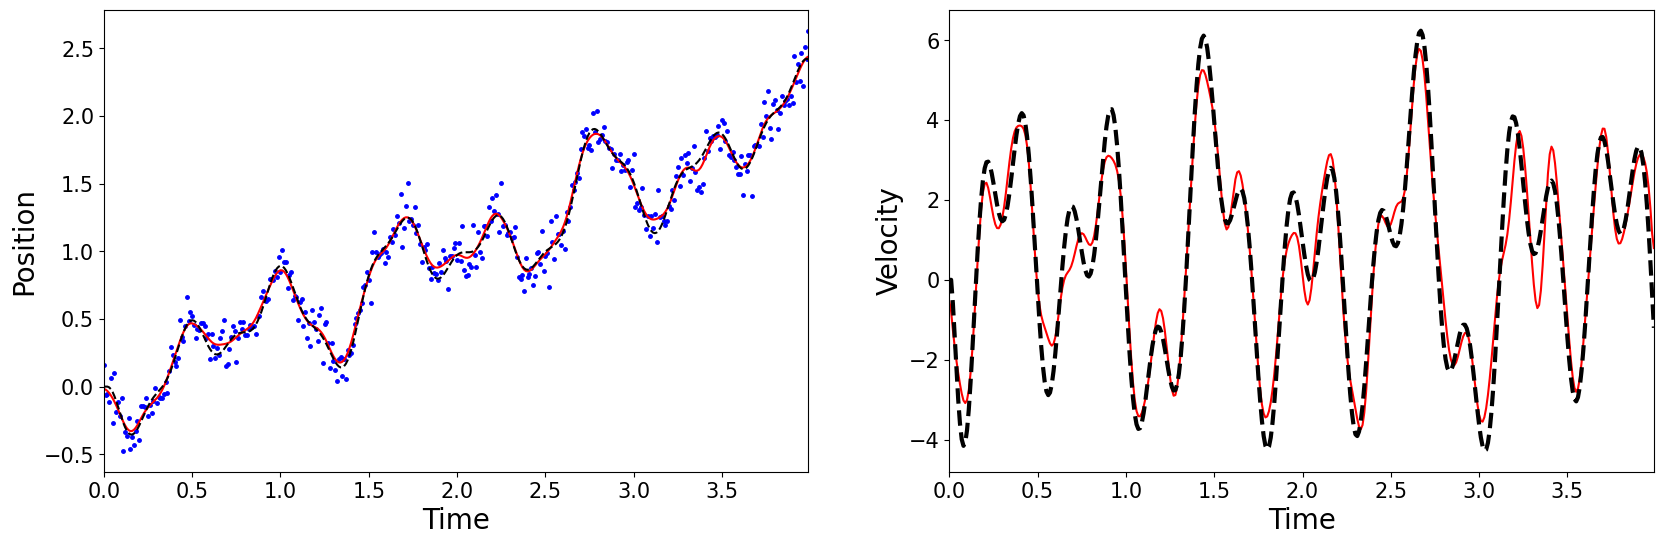

In [6]:
params, val = optimize(meandiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = meandiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.3 Smooth Finite Difference: Gaussian smoothing

Optimal parameters:  {'window_size': 21, 'num_iterations': 1}
RMS error in velocity:  0.642681069052519


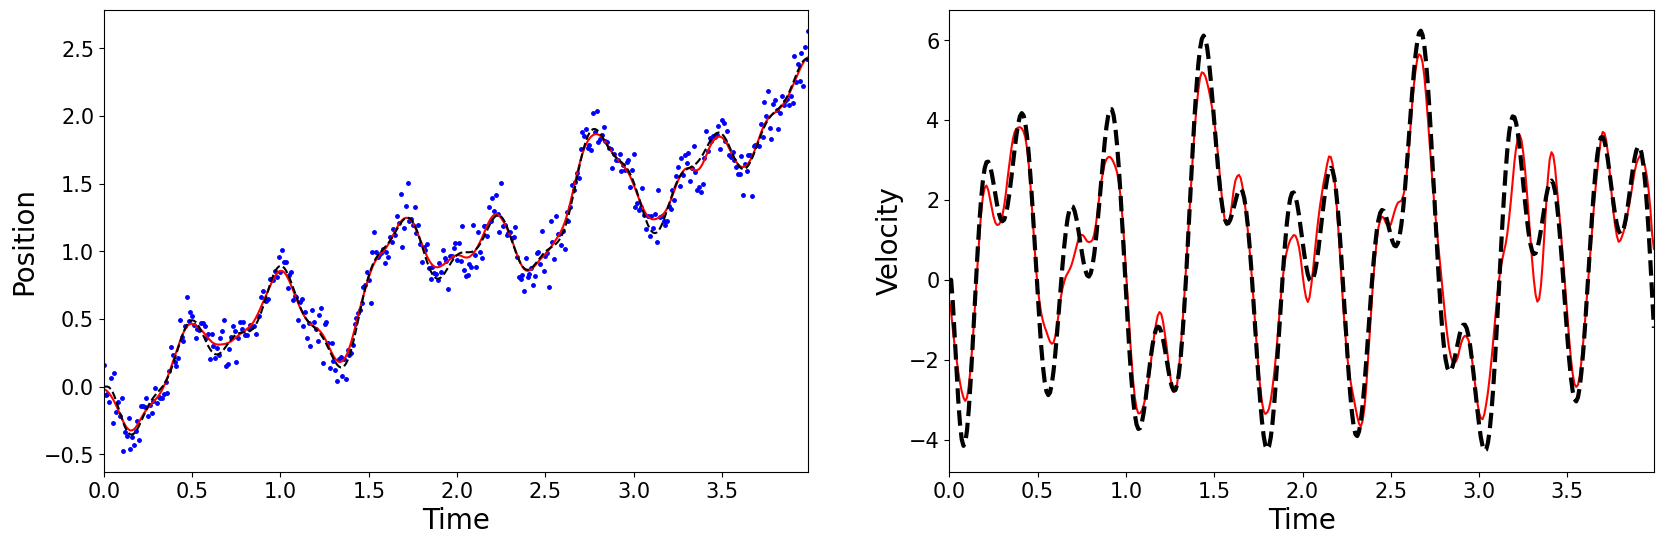

In [7]:
params, val = optimize(gaussiandiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = gaussiandiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.4 Smooth Finite Difference: Friedrichs smoothing

Optimal parameters:  {'window_size': 18, 'num_iterations': 1}
RMS error in velocity:  0.6405307445275004


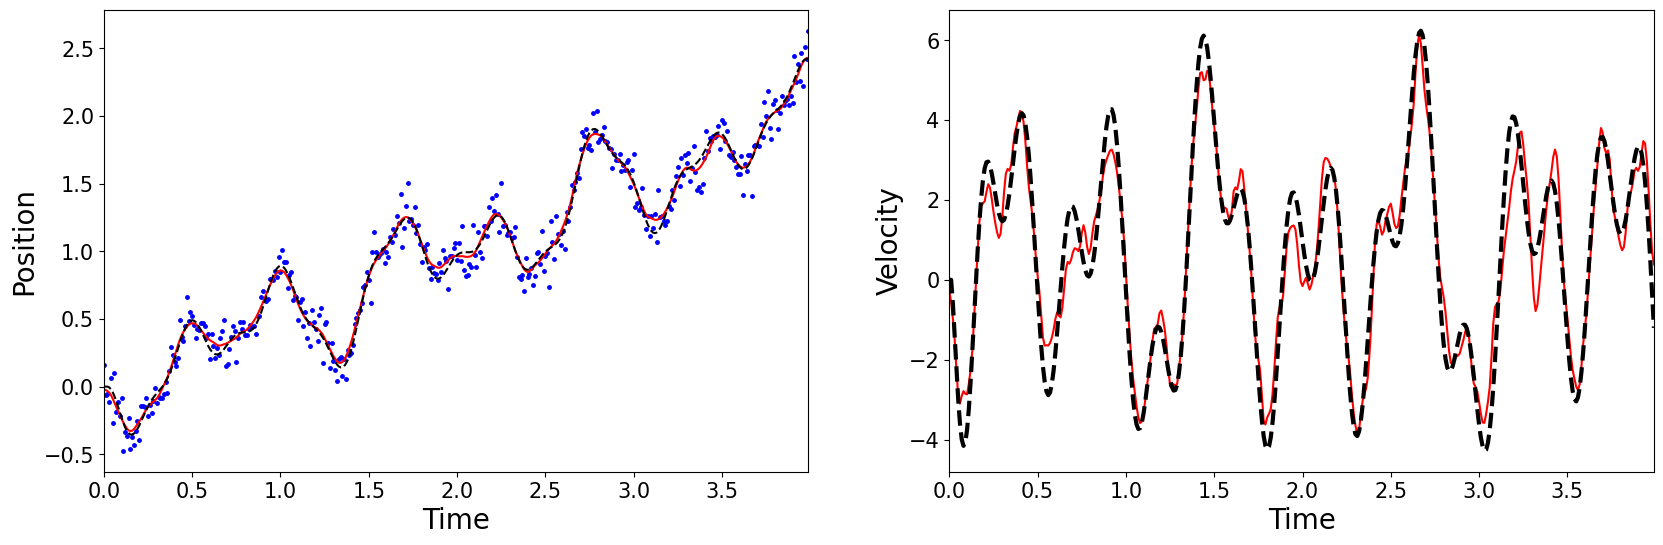

In [8]:
params, val = optimize(friedrichsdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = friedrichsdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.5 Smooth Finite Difference: Butterworth smoothing

Optimal parameters:  {'filter_order': 4, 'cutoff_freq': np.float64(0.14999999999999936), 'num_iterations': 12}
RMS error in velocity:  0.9205816156921752


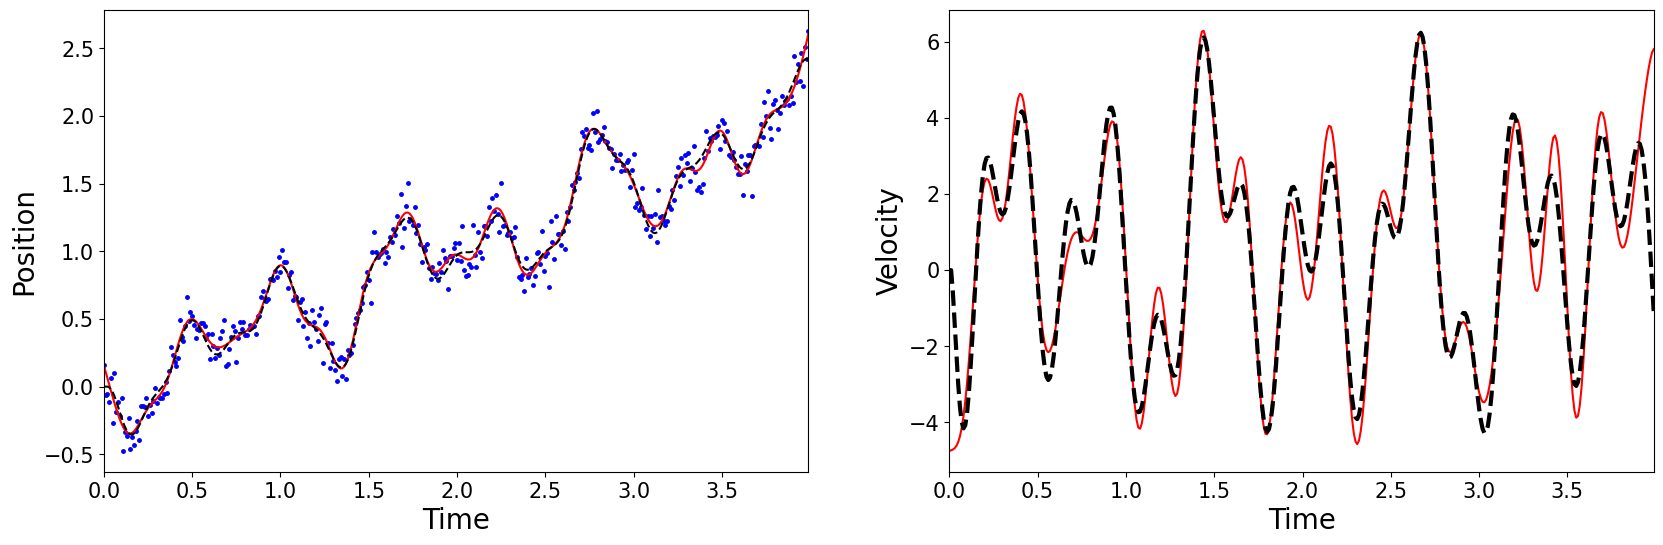

In [9]:
params, val = optimize(butterdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = butterdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.6 Smooth Finite Difference: Spline smoothing

Optimal parameters:  {'order': 3, 's': np.float64(0.4652777777777779), 'num_iterations': 5}
RMS error in velocity:  0.7578276086730573


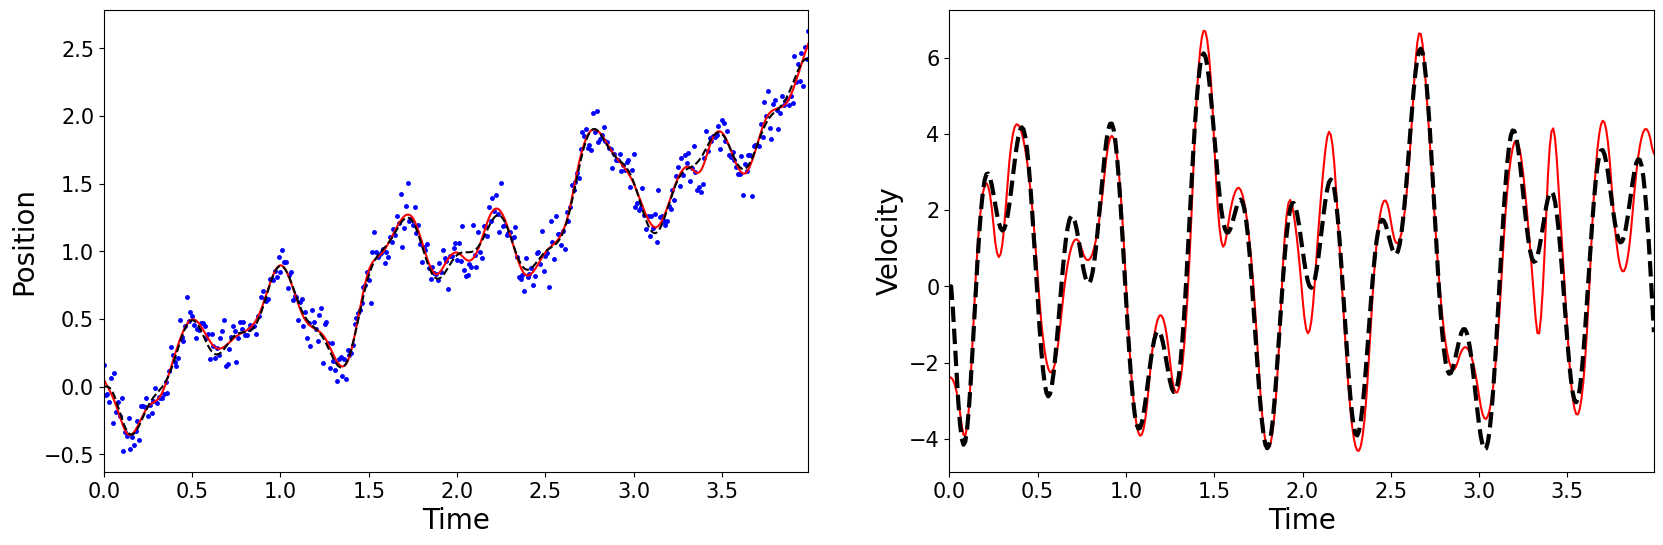

In [10]:
params, val = optimize(splinediff, x, dt, tvgamma=0, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = splinediff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 3. Total Variation Regularization

### 3.1 Iterative Total Variation Regularization (regularized velocity)

Optimal parameters:  {'num_iterations': 4, 'gamma': np.float64(0.0054999999999999875), 'scale': 'small'}
RMS error in velocity:  0.9245541386965488


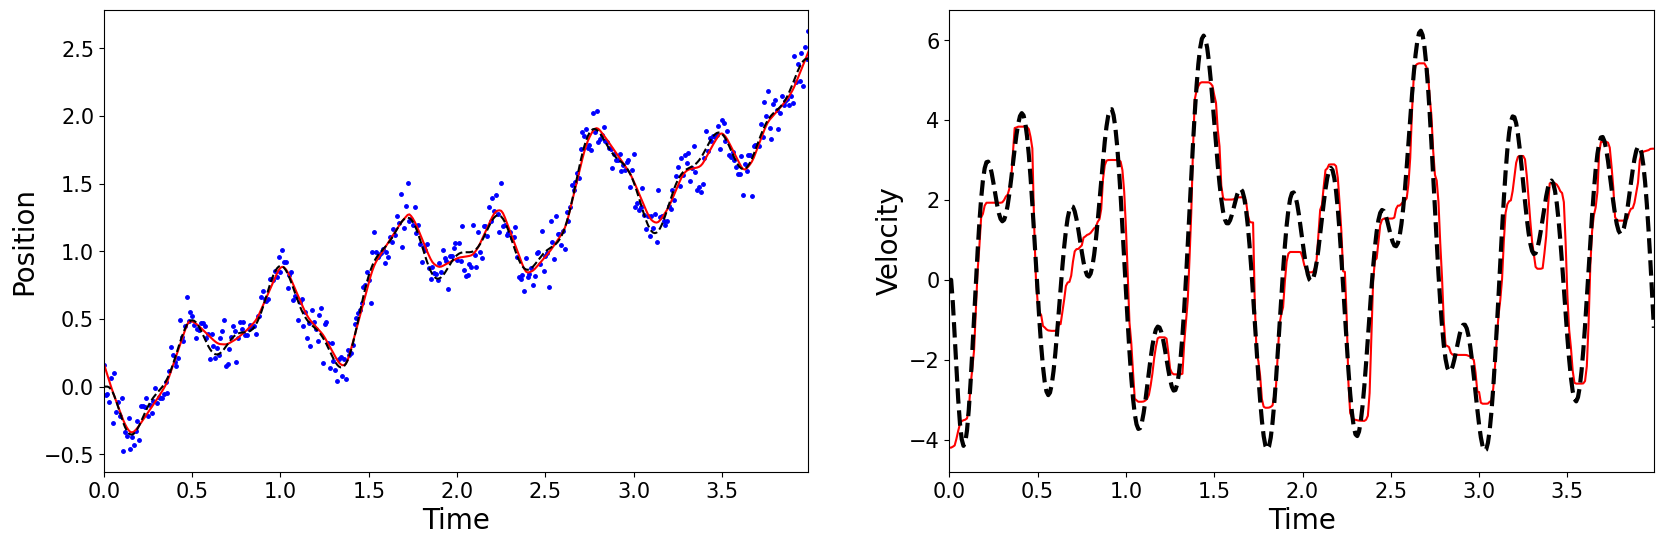

In [11]:
params, val = optimize(iterative_velocity, x, dt, search_space={'num_iterations': [1, 2, 3]}, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = iterative_velocity(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.2 Convex Total Variation Regularization: regularize velocity

Optimal parameters:  {'gamma': np.float64(2.9250000000000043)}
RMS error in velocity:  0.9152876803519941


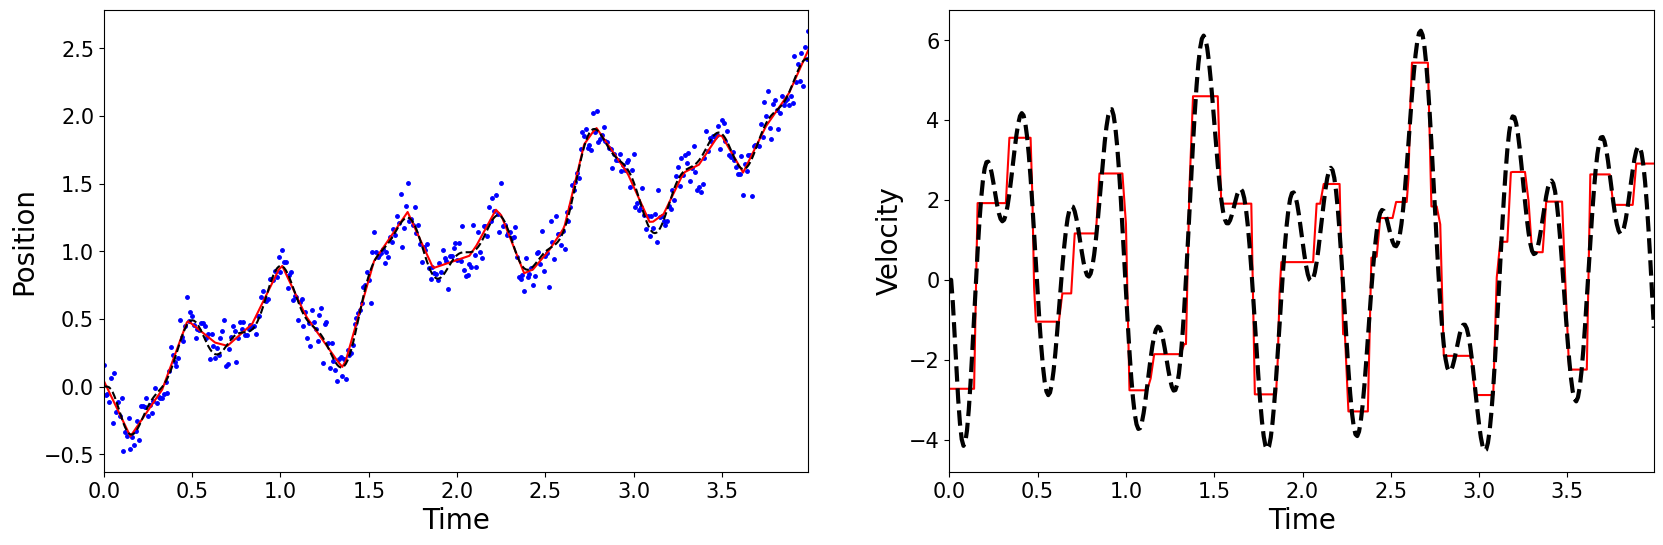

In [12]:
params, val = optimize(velocity, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = velocity(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.3 Convex Total Variation Regularization: regularize acceleration

Optimal parameters:  {'gamma': np.float64(4.350000000000008)}
RMS error in velocity:  0.8589885680548368


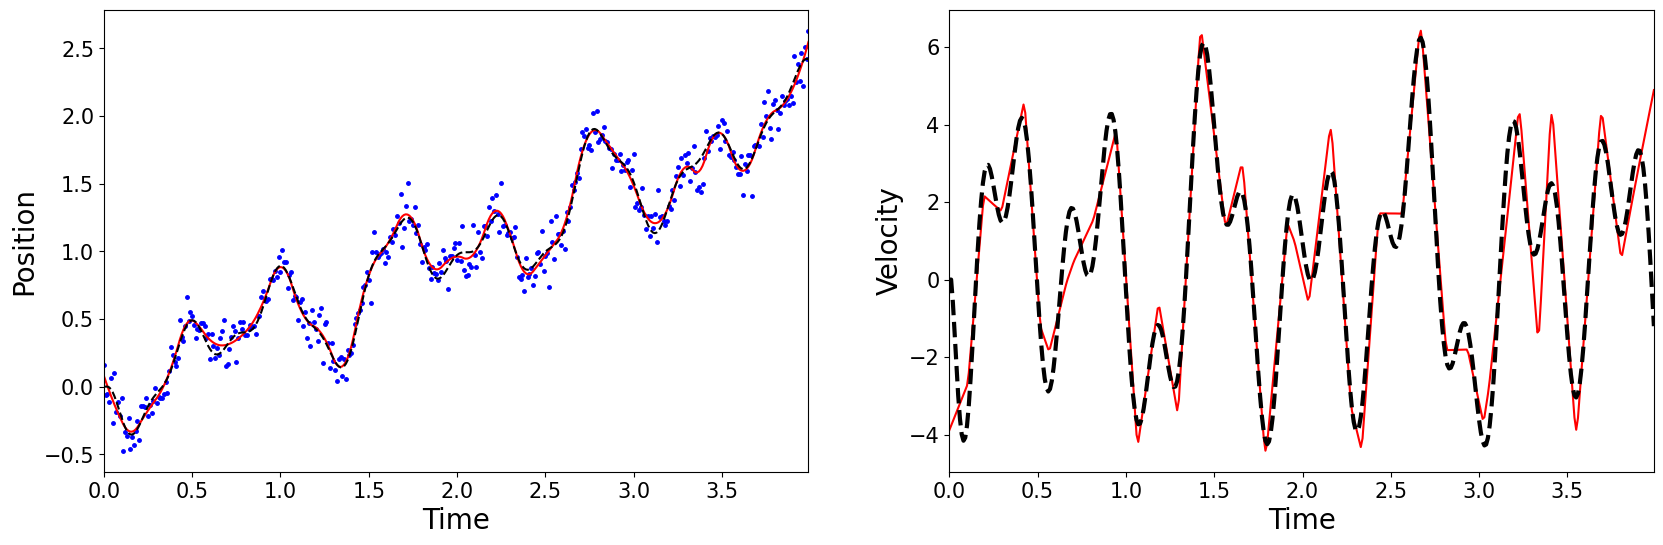

In [13]:
params, val = optimize(acceleration, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = acceleration(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.4 Convex Total Variation Regularization: regularize jerk

Optimal parameters:  {'gamma': np.float64(8.950000000000017)}
RMS error in velocity:  0.7946365332627112


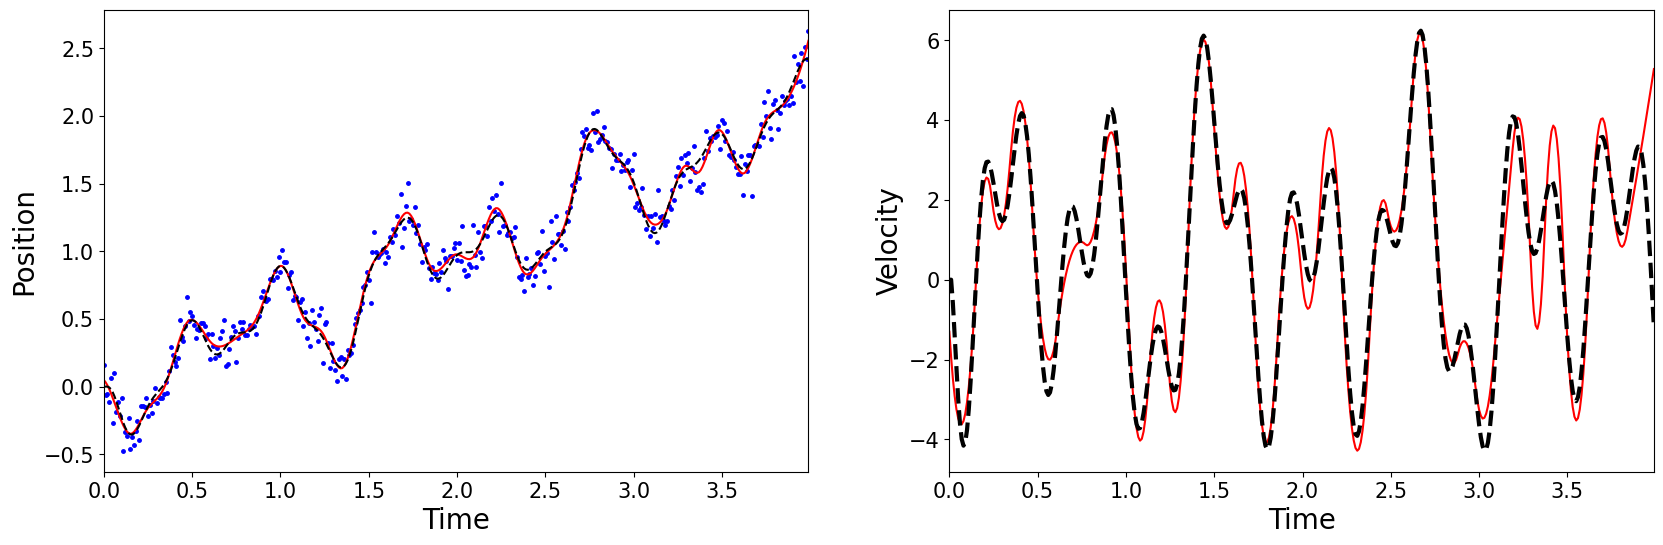

In [14]:
params, val = optimize(jerk, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = jerk(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.5 Convex Total Variation Regularization: regularize acceleration with gaussian smoothing

Optimal parameters:  {'gamma': np.float64(1.3031249999999979), 'window_size': 17}
RMS error in velocity:  0.7633135652698686


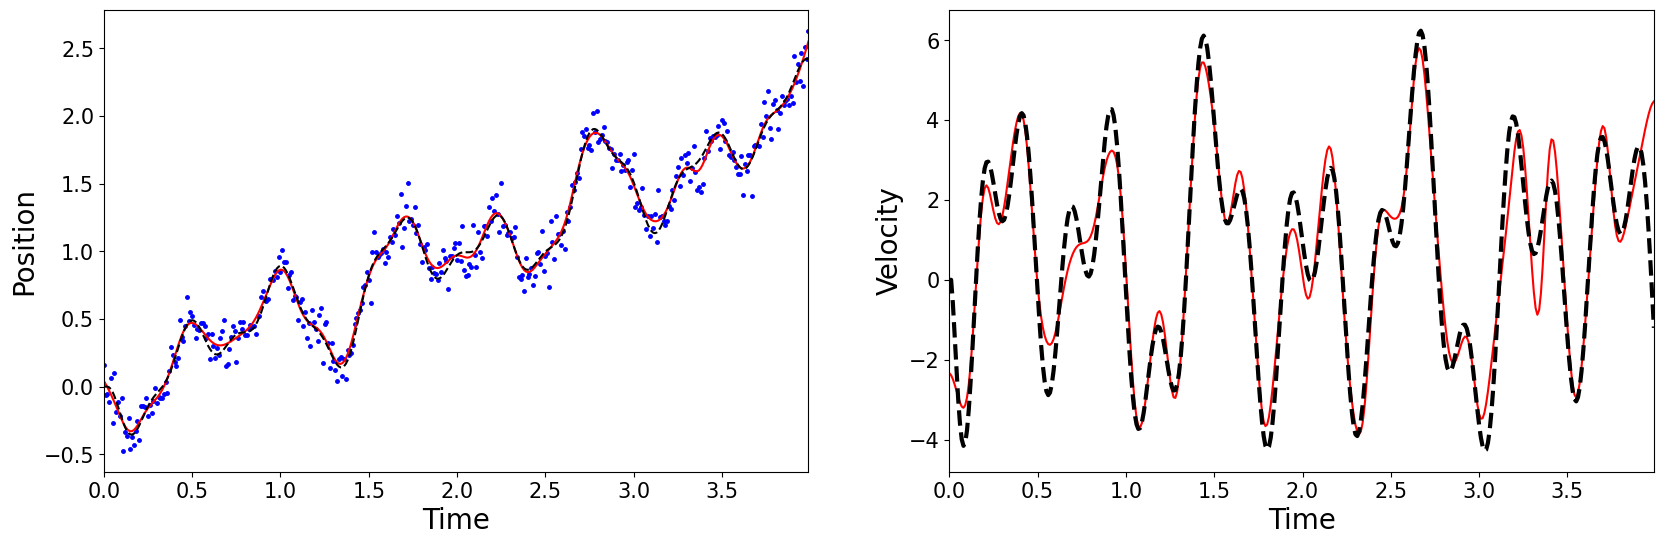

In [15]:
params, val = optimize(smooth_acceleration, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = smooth_acceleration(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 4. Linear Models

### 4.1 Linear Models: Spectral derivative

Optimal parameters:  {'even_extension': np.False_, 'pad_to_zero_dxdt': np.True_, 'high_freq_cutoff': np.float64(0.04185185185185189)}
RMS error in velocity:  0.6231977505714766


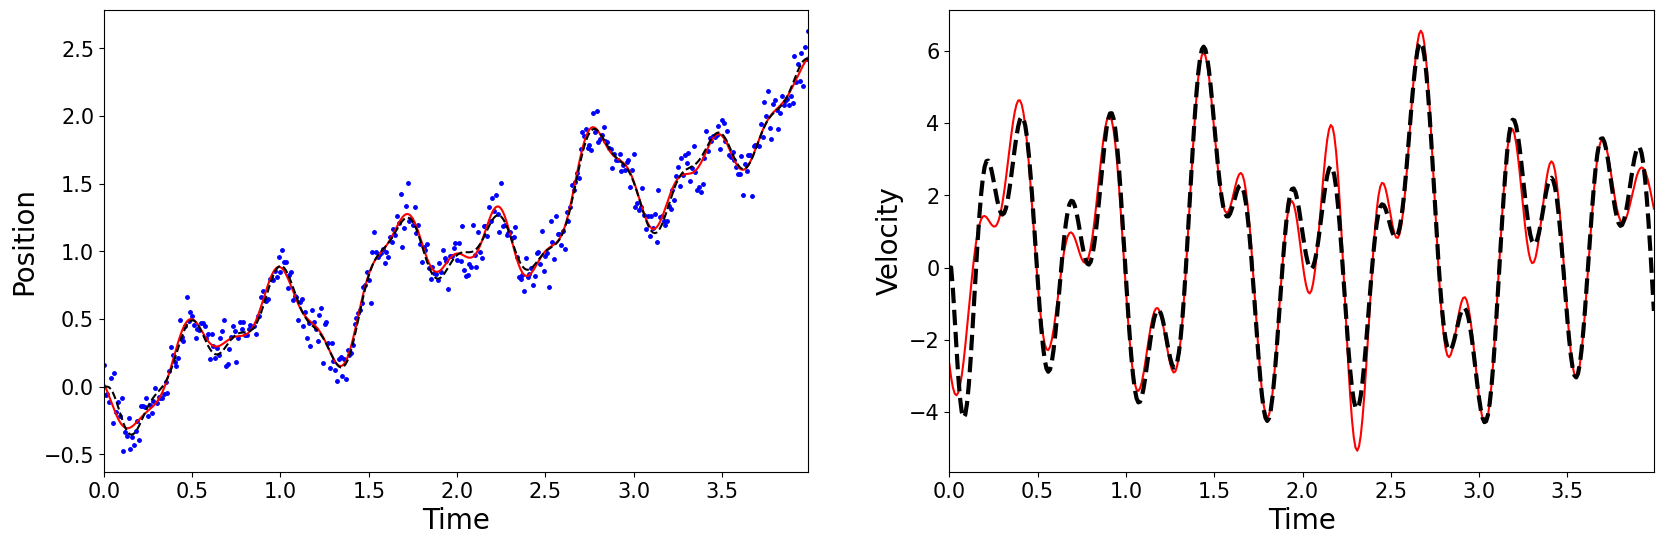

In [16]:
params, val = optimize(spectraldiff, x, dt,
                       search_space={'even_extension': [True, False], 'pad_to_zero_dxdt': [True, False]},
                       dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = spectraldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.2 Linear Models: Sliding polynomial fit

Optimal parameters:  {'step_size': 2, 'poly_order': 2, 'window_size': 29, 'kernel': 'friedrichs'}
RMS error in velocity:  0.7277649206991202


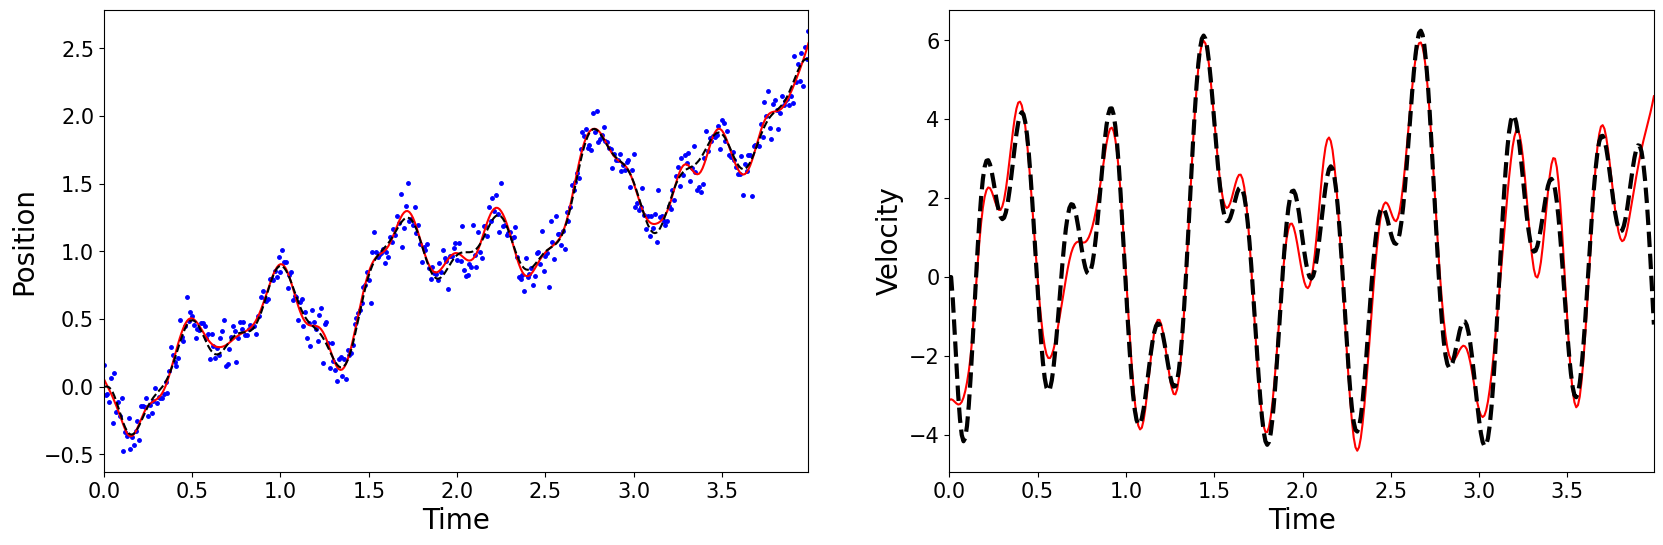

In [17]:
params, val = optimize(polydiff, x, dt, search_space={'step_size':[1, 2, 5]}, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = polydiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.3 Linear Models: Savitzky-Golay filter

Optimal parameters:  {'poly_order': 5, 'window_size': 39, 'smoothing_win': 13}
RMS error in velocity:  0.6340064287423233


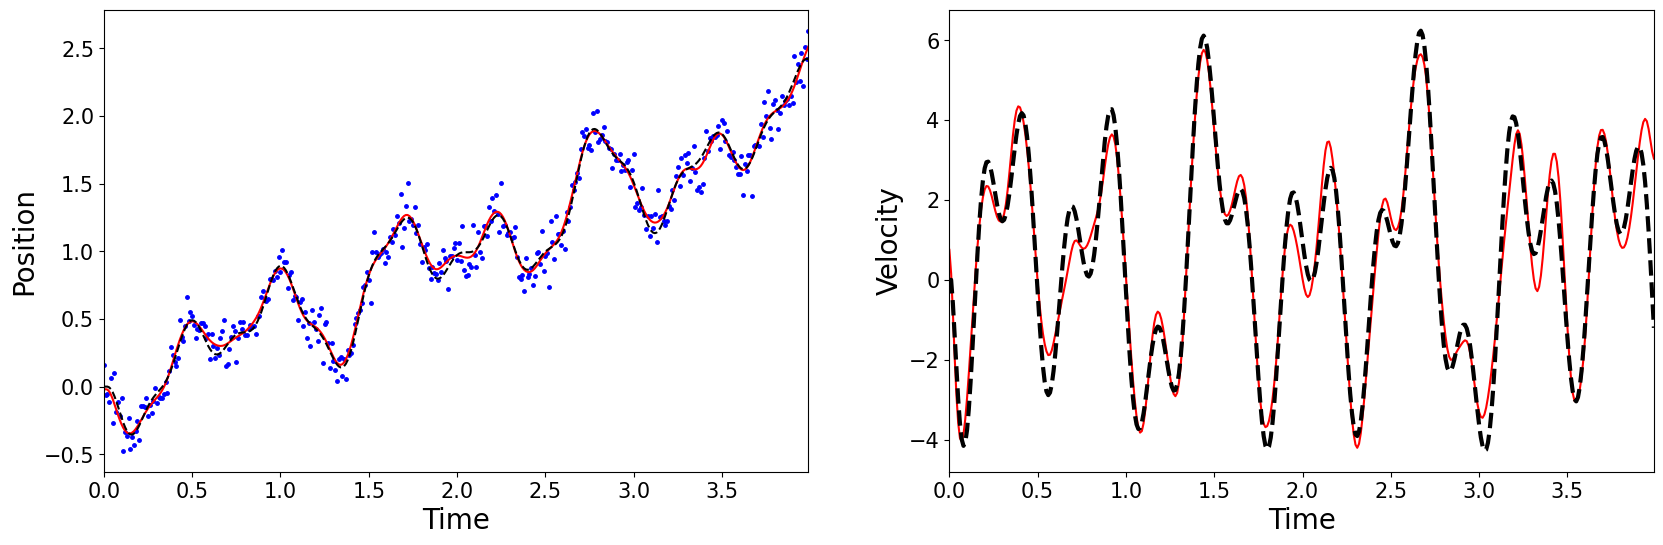

In [18]:
params, val = optimize(savgoldiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = savgoldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.4 Linear Models: Sliding chebychev polynomial fit - removed to simplify requirements

### 4.5 Linear Models: Sliding linear time invariant system fit

In [19]:
if 0: # this one is too slow and runtime error prone!
    params, val = optimize(lineardiff, x, dt, dxdt_truth=dxdt_truth)
    print('Optimal parameters: ', params)
    x_hat, dxdt_hat = lineardiff(x, dt, **params)
    evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## Kalman smoothing

### 5.1 Kalman smoothing: constant velocity

Optimal parameters:  {'forwardbackward': np.False_, 'q': np.float64(1222.2222222222044), 'r': np.float64(14.77777777777776)}
RMS error in velocity:  0.7065017359778757


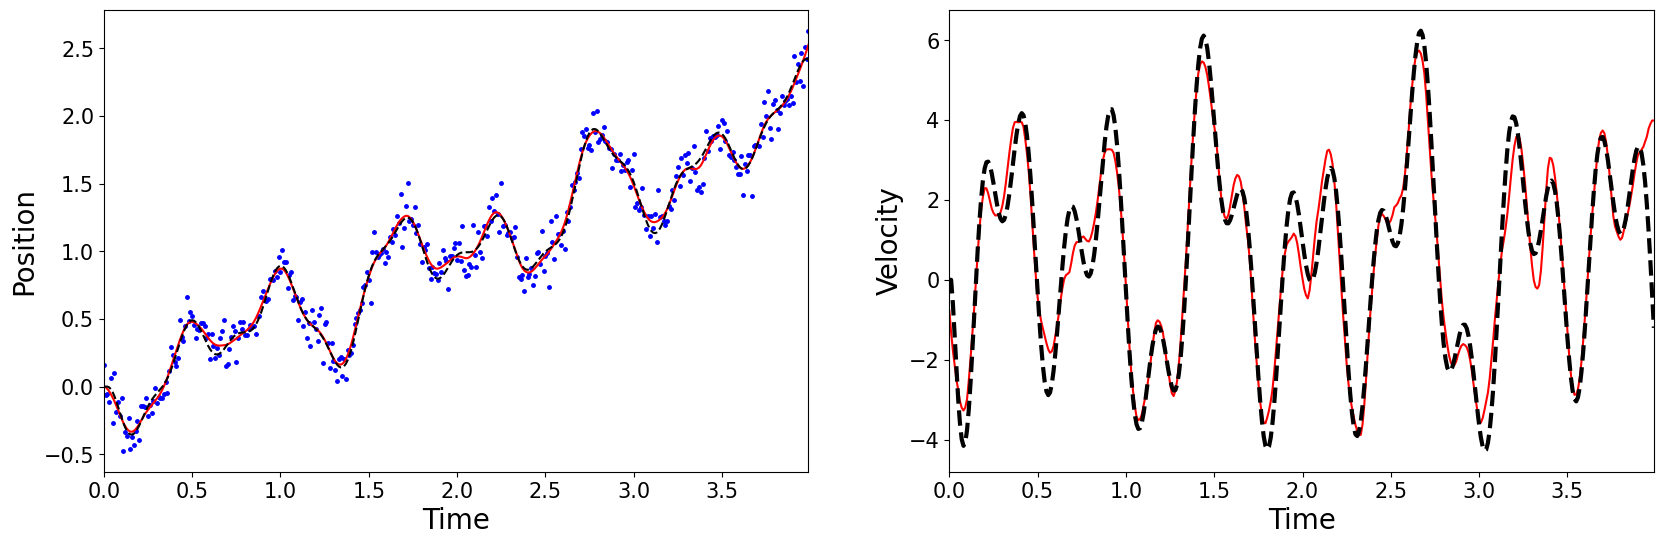

In [20]:
params, val = optimize(constant_velocity, x, dt, search_space={'forwardbackward': [True, False]}, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = constant_velocity(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 5.2 Kalman smoothing: constant acceleration

Optimal parameters:  {'forwardbackward': np.False_, 'q': np.float64(151666666.66666645), 'r': np.float64(2333.333333333314)}
RMS error in velocity:  0.7115825572585116


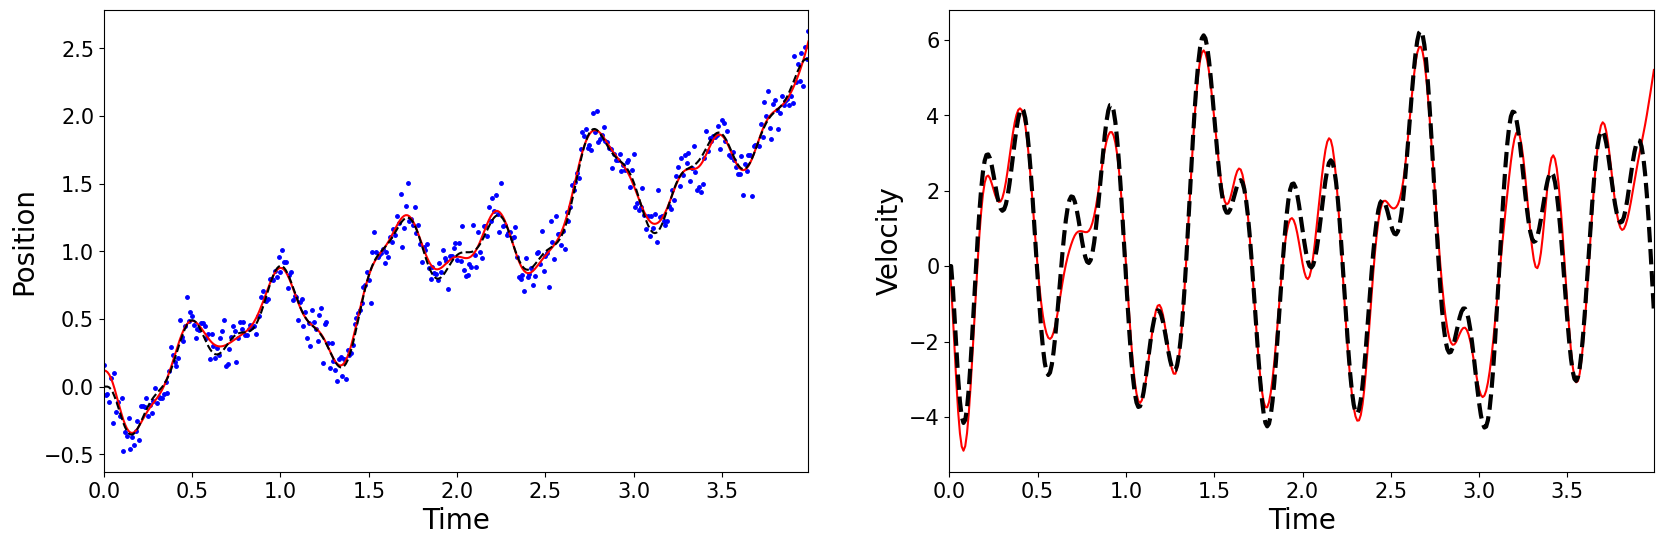

In [21]:
params, val = optimize(constant_acceleration, x, dt, search_space={'forwardbackward': [True, False]}, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = constant_acceleration(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 5.3 Kalman smoothing: constant jerk

Optimal parameters:  {'forwardbackward': np.False_, 'q': np.float64(151666666.66666645), 'r': np.float64(2.3333333333333464)}
RMS error in velocity:  0.712132339106883


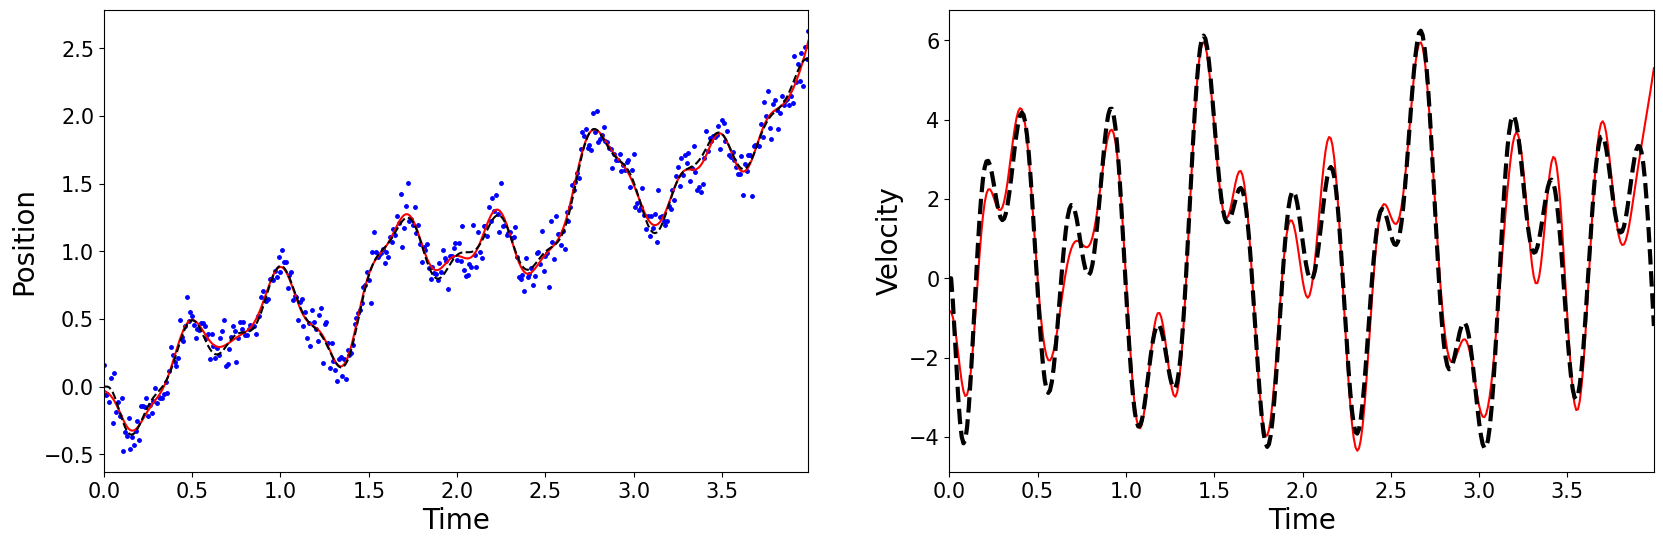

In [22]:
params, val = optimize(constant_jerk, x, dt, search_space={'forwardbackward': [True, False]}, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = constant_jerk(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)